**Table of contents**<a id='toc0_'></a>    
- [Titanic survivor prediction](#toc1_)    
  - [Loading the dataset](#toc1_1_)    
  - [Data exploration](#toc1_2_)    
    - [Null values](#toc1_2_1_)    
    - [How each column correlates with survivability](#toc1_2_2_)    
  - [Data preprocessing](#toc1_3_)    
    - [Age groups](#toc1_3_1_)    
    - [One Hot Encoding](#toc1_3_2_)    
    - [Final adjust](#toc1_3_3_)    
    - [Final function](#toc1_3_4_)    
  - [Model](#toc1_4_)    
  - [Tree classifier](#toc1_5_)    
  - [Final evaluation](#toc1_6_)    
  - [Different imputations for missing age](#toc1_7_)    
    - [Mean](#toc1_7_1_)    
    - [Model prediction](#toc1_7_2_)    
    - [Classify by age](#toc1_7_3_)    
  - [Submission](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Titanic survivor prediction](#toc0_)
This notebook contains my solution to the most famous problem on Kaggle: predicting which passengers survived the titanic disaster

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# random state used in all notebook
rstate = 7

## <a id='toc1_1_'></a>[Loading the dataset](#toc0_)

In [121]:
raw_titanic_data = pd.read_csv('data/titanic/train.csv', index_col='PassengerId')
raw_titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [122]:
# we are going to use the raw data later
titanic_data = raw_titanic_data.copy()

In [123]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## <a id='toc1_2_'></a>[Data exploration](#toc0_)

First, let's see if the data is valid. Since thete are only 11 columns, we can check them individually

In [124]:
def plot_counts(df, column):
    """Plot the value counts for a column in a dataframe
    """
    df[column].value_counts().plot(kind='bar')
    plt.xlabel(column)
    plt.ylabel('Count')

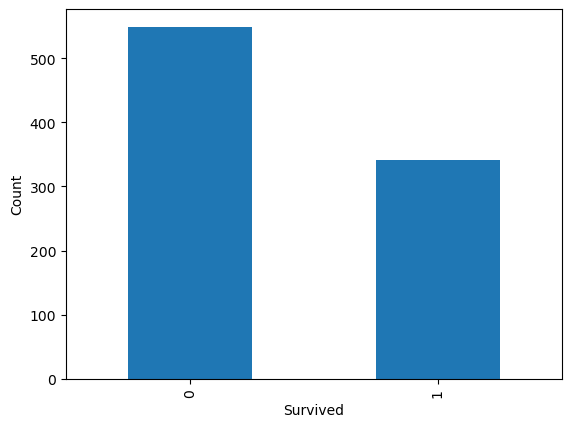

In [125]:
plot_counts(titanic_data, 'Survived')

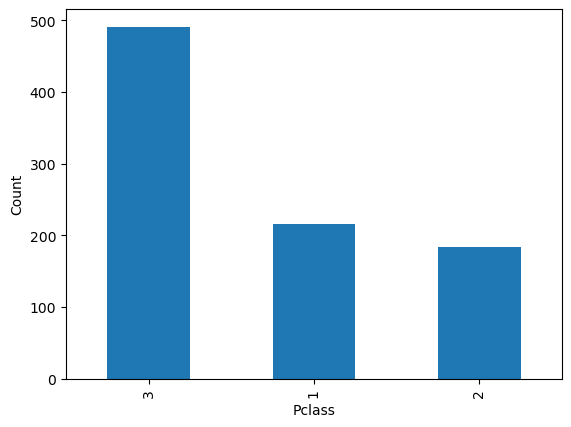

In [126]:
plot_counts(titanic_data, 'Pclass')

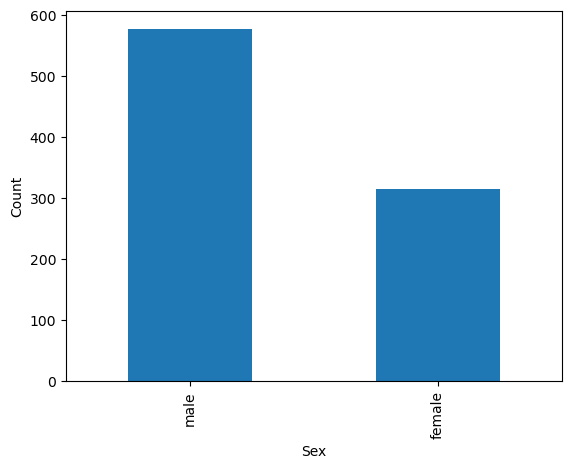

In [127]:
plot_counts(titanic_data, 'Sex')

In [128]:
titanic_data[['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


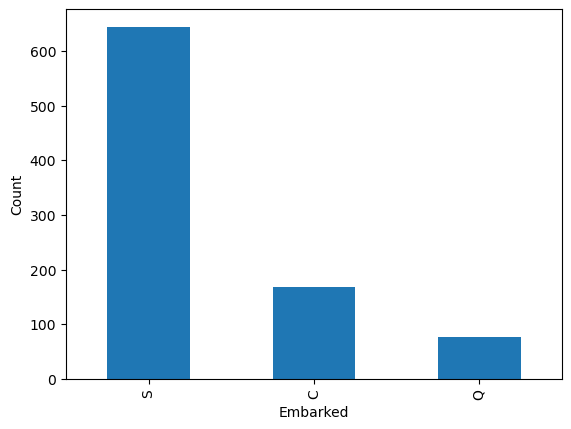

In [129]:
plot_counts(titanic_data, 'Embarked')

The values are all valid. We are going to check the null values

### <a id='toc1_2_1_'></a>[Null values](#toc0_)

In [130]:
titanic_data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

The null values are in Age, Cabin and Embarked. Let's check

In [131]:
titanic_data[titanic_data['Age'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [132]:
titanic_data[titanic_data['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [133]:
titanic_data[~titanic_data['Cabin'].isna()].head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C


Cabin has so many null values, and at first seems to have no relation with the other info. We are going to ignore this column.

Age is a important column with many null values. We will try different imputations for this one. At first, we are going to impute the mean age.

Embarked has only two missing values, so let's just fill these with the mode

In [134]:
# filling the embarked with mode
emb_mode = titanic_data['Embarked'].mode()[0]
titanic_data['Embarked'] = titanic_data['Embarked'].fillna(emb_mode)

# filling the age with mean
age_mean = titanic_data['Age'].mean()
titanic_data['Age'] = titanic_data['Age'].fillna(age_mean)

# cabin drop
titanic_data = titanic_data.drop(columns=['Cabin'])

### <a id='toc1_2_2_'></a>[How each column correlates with survivability](#toc0_)

In [135]:
def plot_survived_by_column(titanic_data, column):
    """Plot how many survived on side of the total for a categorical column
    """
    
    group = titanic_data.groupby(column)
    ind = np.arange(len(group))
    width = 0.35

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.bar(ind, group['Survived'].count(), width, label='Total')
    ax.bar(ind+width, group['Survived'].sum(), width, label='Survived')

    

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(group['Survived'].count().index)
    ax.legend()
    ax.set_ylabel('Count')
    ax.set_xlabel(column)

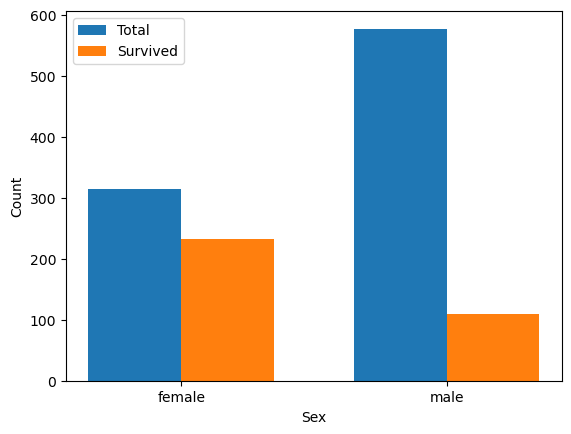

In [136]:
plot_survived_by_column(titanic_data, 'Sex')

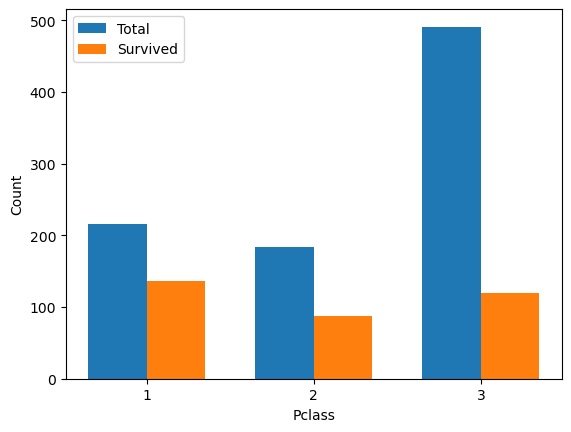

In [137]:
plot_survived_by_column(titanic_data, 'Pclass')

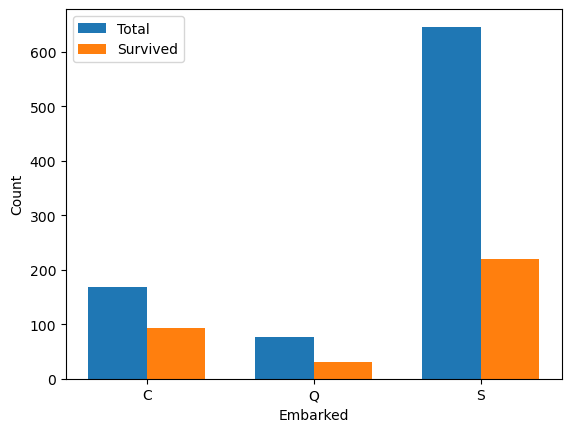

In [138]:
plot_survived_by_column(titanic_data, 'Embarked')

In [139]:
def percentages_of_survivability(titanic_data, column):
    """Return the percentage of survivability for each value in a column"""
    survival = titanic_data.groupby(column)['Survived'].agg(['count', 'sum'])
    survival = survival.rename(columns={'sum': 'Survived', 'count': 'Total'})
    survival['Survivability [%]'] = survival['Survived'] / survival['Total'] * 100
    return survival

In [140]:
# since this one is not so clear by the graph, lets calculate the percentage
# of survivability for each
percentages_of_survivability(titanic_data, 'Embarked')

,Total,Survived,Survivability [%]
Embarked,,,
C,168,93,55.357143
Q,77,30,38.961039
S,646,219,33.900929


What we can see
- Sex: Female has a lot more chance of survival. Makes sense because the rule for the life boats give a preference for them
- Pclass: the higher the class of the ticket, higher the chance of survival, as expected, because richer people are in the higher cabins.
- Embarked: Seems to make a difference, but it's not clear why. Maybe a correlation for the port with other data.

Text(0, 0.5, 'Fare')

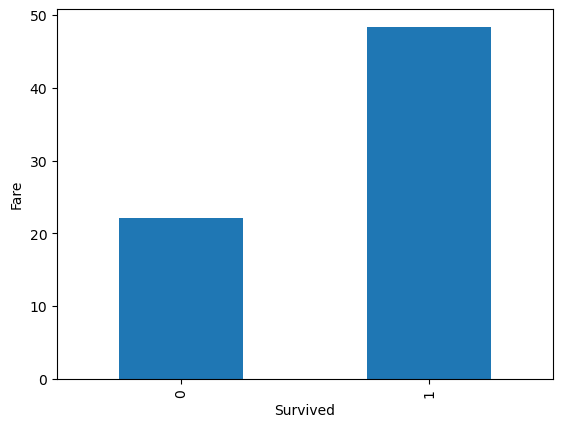

In [141]:
titanic_data.groupby('Survived').Fare.mean().plot(kind='bar')
plt.ylabel('Fare')

The passengers with higher fare had a grater chance of surviving

In [142]:
percentages_of_survivability(titanic_data, 'SibSp')

,Total,Survived,Survivability [%]
SibSp,,,
0,608,210,34.539474
1,209,112,53.588517
2,28,13,46.428571
3,16,4,25.000000
4,18,3,16.666667
5,5,0,0.000000
8,7,0,0.000000


In [143]:
percentages_of_survivability(titanic_data, 'Parch')

,Total,Survived,Survivability [%]
Parch,,,
0,678,233,34.365782
1,118,65,55.084746
2,80,40,50.000000
3,5,3,60.000000
4,4,0,0.000000
5,5,1,20.000000
6,1,0,0.000000


We can see that having a sibling, spouse or parent seems to increase the chance of surviving. If the quantity matters, it's hard to know since for values higher than two we have only few samples, but seems that having a greater number seems to reduce the chance. For the SibSp for example, where it is higher than 3 the survivability goes very low

## <a id='toc1_3_'></a>[Data preprocessing](#toc0_)

### <a id='toc1_3_1_'></a>[Age groups](#toc0_)

We will do some feature engenerring on the age column, to group people into age classes, since the young had preference to go on the life boats.

In [144]:
def create_age_group(titanic_data, minage, maxage, name, enc):
    titanic_data.loc[(titanic_data['Age'] >= minage) & (titanic_data['Age'] < maxage), 'AgeGroup'] = name
    titanic_data.loc[(titanic_data['Age'] >= minage) & (titanic_data['Age'] < maxage), 'AgeGroupEn'] = enc

    
def groups_of_age(titanic_data):
    """Create groups based on the age, from Child to Elder.
    Generates a categorical column and a encoded column"""
    
    titanic_data['AgeGroup'] = None
    titanic_data['AgeGroupEn'] = 0
    
    groups = [
        [0, 9, 'Child', 0],
        [9, 18, 'Teen', 1],
        [18, 30, 'Young', 2],
        [30, 60, 'Adult', 3],
        [60, 81, 'Elder', 4]
    ]

    for minage, maxage, name, enc in groups:
        create_age_group(titanic_data, minage, maxage, name, enc)
        
    return titanic_data


In [145]:
titanic_data = groups_of_age(titanic_data)

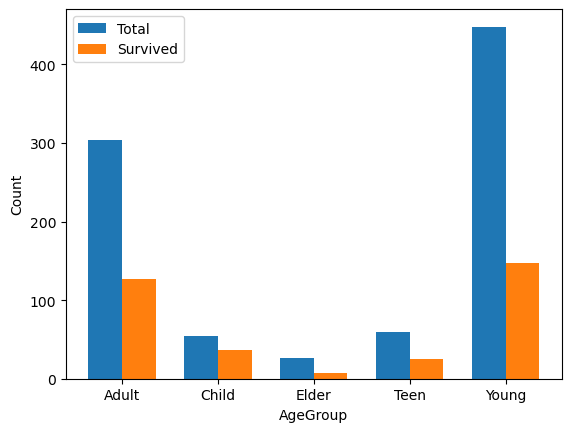

In [146]:
plot_survived_by_column(titanic_data, 'AgeGroup')

In [147]:
print('Percentages of survivability')
embarked_survival = titanic_data.groupby('AgeGroup')['Survived'].agg(['count', 'sum'])
(embarked_survival['sum'] / embarked_survival['count'] * 100).sort_values(ascending=False)

Percentages of survivability


AgeGroup
Child    66.666667
Teen     42.372881
Adult    41.776316
Young    32.812500
Elder    26.923077
dtype: float64

As expected, the child has the greater survivability, since they had preference to go on the life boats. The elder had the smaller chance of survival, probably because the lack of preferrence and difficulties to get to the life boats.

### <a id='toc1_3_2_'></a>[One Hot Encoding](#toc0_)
One hot encoding the categorical columns to put in the model

In [148]:
titanic_data = pd.get_dummies(titanic_data, columns=['Sex', 'Embarked'], drop_first=True)

### <a id='toc1_3_3_'></a>[Final adjust](#toc0_)
Let's do a final adjustement to our data by dropping the unecessary columns

In [149]:
titanic_data.drop(columns=['Name', 'Ticket', 'AgeGroup'])

,Survived,Pclass,Age,SibSp,Parch,Fare,AgeGroupEn,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,3,22.000000,1,0,7.2500,2,1,0,1
2,1,1,38.000000,1,0,71.2833,3,0,0,0
3,1,3,26.000000,0,0,7.9250,2,0,0,1
4,1,1,35.000000,1,0,53.1000,3,0,0,1
5,0,3,35.000000,0,0,8.0500,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.000000,0,0,13.0000,2,1,0,1
888,1,1,19.000000,0,0,30.0000,2,0,0,1
889,0,3,29.699118,1,2,23.4500,2,0,0,1


### <a id='toc1_3_4_'></a>[Final function](#toc0_)
Build a function that does all the treatment nedded


In [150]:
def data_process(raw_titanic_data):
    
    titanic_data = raw_titanic_data
    
    # filling the embarked with mode
    emb_mode = titanic_data['Embarked'].mode()[0]
    titanic_data['Embarked'] = titanic_data['Embarked'].fillna(emb_mode)

    # filling the age with mean
    age_mean = titanic_data['Age'].mean()
    titanic_data['Age'] = titanic_data['Age'].fillna(age_mean)

    # cabin drop
    titanic_data = titanic_data.drop(columns=['Cabin'])
    
    titanic_data = groups_of_age(titanic_data)
    
    titanic_data = pd.get_dummies(titanic_data, columns=['Sex', 'Embarked'], drop_first=True)
    
    titanic_data = titanic_data.drop(columns=['Name', 'Ticket', 'AgeGroup'])
    
    return titanic_data

## <a id='toc1_4_'></a>[Model](#toc0_)

To do our model, we will first use Random Forest, that is good for a first choose of model, because it is robust to outliers, does feature selection automatically, etc.

We will use cross validation to do hyperparameter tuning of our model, using KFolds, and GridSearch.

We already have our test data separed, so let's divide the data into train and validation

In [151]:
target = 'Survived'

titanic_data = data_process(raw_titanic_data)
X = titanic_data[[col for col in titanic_data.columns if col != target]]
y = titanic_data[target]
X.shape, y.shape

((891, 9), (891,))

In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(1, 15),
    'max_features': [1, 'sqrt', 'log2'],
    'n_estimators': [10, 50, 100, 200, 500, 1000]
}

model = RandomForestClassifier(random_state=rstate)

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=4, return_train_score=True, verbose=1, n_jobs=-3)

grid_search.fit(X, y)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
# filtering the results
results = pd.DataFrame(grid_search.cv_results_)
relevant_columns = ['mean_train_score', 'mean_test_score'] + ['param_' + x for x in param_grid.keys()]
results = results[relevant_columns]
results = results.sort_values('mean_test_score', ascending=False)

# invert the signal for better vizualization
results[['mean_train_score', 'mean_test_score']] = - results[['mean_train_score', 'mean_test_score']]

Fitting 4 folds for each of 252 candidates, totalling 1008 fits


Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}


In [186]:
results.head(10)

,mean_train_score,mean_test_score,param_max_depth,param_max_features,param_n_estimators
177,-0.948000,-0.838393,10,log2,200
171,-0.948000,-0.838393,10,sqrt,200
65,-0.850732,-0.836146,4,sqrt,1000
71,-0.850732,-0.836146,4,log2,1000
153,-0.935653,-0.835025,9,sqrt,200
159,-0.935653,-0.835025,9,log2,200
160,-0.936402,-0.835020,9,log2,500
154,-0.936402,-0.835020,9,sqrt,500
70,-0.849609,-0.833904,4,log2,500
64,-0.849609,-0.833904,4,sqrt,500


In [187]:
# useful functions for hyperparameter analysis

def plot_train_validation_score_curve(results, param):
    """Plot the train x validation score curve to localize where overfit begins to happen"""
    results_p = results.sort_values(param)

    plt.plot(results_p[param], results_p['mean_train_score'], marker='x', label='Train score')
    plt.plot(results_p[param], results_p['mean_test_score'], marker='o', label='Test Score')
    plt.xlabel(param)
    plt.ylabel('score')
    plt.legend()
    

def plot_train_validation_score_curve_all(results, param, show_tests=True):
    """Plot the train x validation score curve to localize where overfit begins to happen
    Plot a mean curve, and individual tests"""
    results = results.sort_values(param)

    if show_tests:
        plt.scatter(results[param], results['mean_train_score'], marker='x', label='train scores', alpha=0.5)
        
    plt.plot(results[param].unique(), results.groupby(param)['mean_train_score'].mean(), marker='o', label='Train score mean')

    if show_tests:
        plt.scatter(results[param], results['mean_test_score'], label='test_scores', marker='x', alpha=0.5)
        
    plt.plot(results[param].unique(), results.groupby(param)['mean_test_score'].mean(),marker='o', label='Test score mean')

    plt.xlabel(param)
    plt.ylabel('Score')
    plt.legend()
    
    
def plot_variation_score(results):
    """Plot the variation of the score when a hyperparameter changes individually
    This can show how much impact this hyperparameter has on the model"""
    params = [col for col in results.columns if col.startswith('param_')]
    params_std = []
    for param in params:
        std = results.groupby(param)['mean_test_score'].mean().std()
        params_std.append(std)
        
    plt.barh(params, params_std)
    plt.xlabel('std')
    
    
def plot_feature_importances(model):
    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(12,5))
    forest_importances[:20].plot.barh(ax=ax).invert_yaxis()
    ax.set_title("Feature importances for prediction")
    ax.set_ylabel("Top most important features")
    ax.set_xlabel('Importance')
    fig.tight_layout()

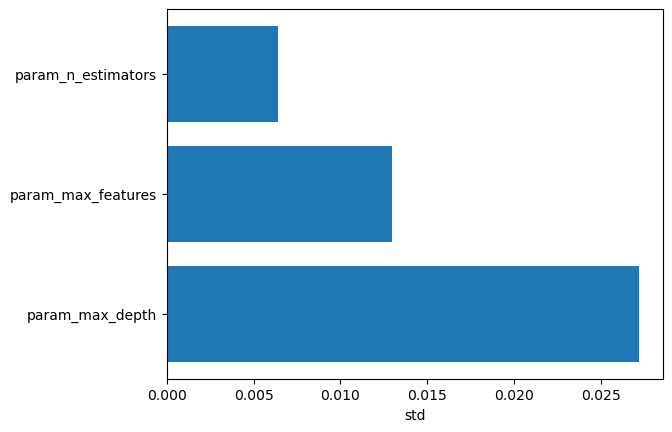

In [189]:
plot_variation_score(results)

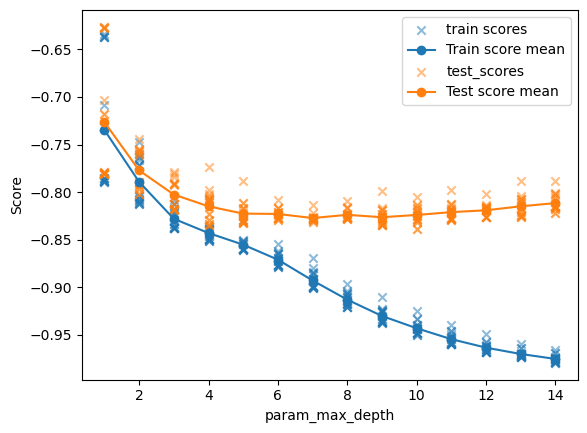

In [191]:
plot_train_validation_score_curve_all(results, 'param_max_depth')

The overfit starts on 7, so 7 seems a good choice

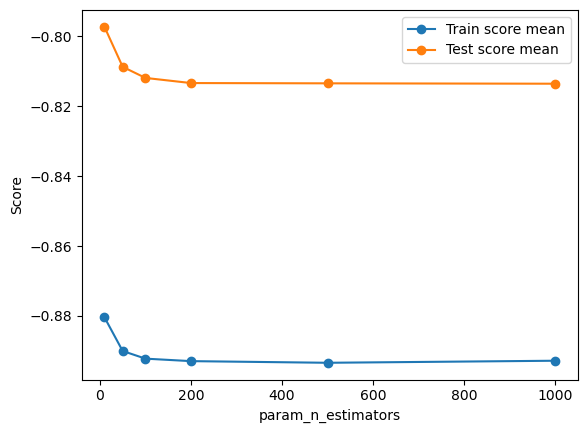

In [192]:
plot_train_validation_score_curve_all(results, 'param_n_estimators', show_tests=False)

Anything above 200 seems a good choice

<Axes: xlabel='param_max_features', ylabel='mean_test_score'>

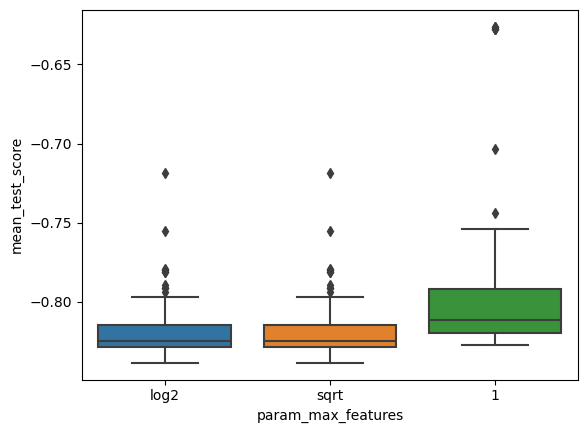

In [193]:
sns.boxplot(results, x='param_max_features', y='mean_test_score')

For this one, it's hard to know looking isolate, but sqrt gives better results on general.

In [211]:
final_model = RandomForestClassifier(max_depth=4, max_features='log2', n_estimators=1000, random_state=rstate)
final_model.fit(X, y)

RandomForestClassifier(max_depth=4, max_features='log2', n_estimators=1000,
                       random_state=7)

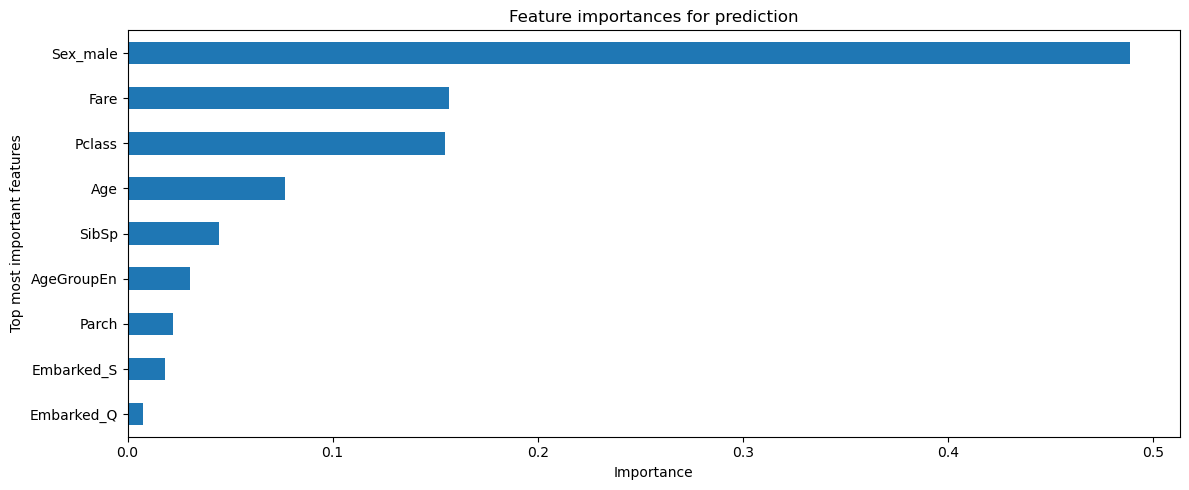

In [212]:
plot_feature_importances(final_model)

## Test data

In [213]:
test_data = pd.read_csv('data/titanic/test.csv', index_col="PassengerId")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


Different from the train data, here we have missing value on Fare. It's only one value, so let's impute the mean and do the process done on the train data

In [214]:
# missing values, this can have a better treatment
test_data.loc[test_data['Fare'].isna(), 'Fare'] = test_data['Fare'].mean()
test_data = data_process(test_data)
test_data

,Pclass,Age,SibSp,Parch,Fare,AgeGroupEn,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
892,3,34.50000,0,0,7.8292,3,1,1,0
893,3,47.00000,1,0,7.0000,3,0,0,1
894,2,62.00000,0,0,9.6875,4,1,1,0
895,3,27.00000,0,0,8.6625,2,1,0,1
896,3,22.00000,1,1,12.2875,2,0,0,1
...,...,...,...,...,...,...,...,...,...
1305,3,30.27259,0,0,8.0500,3,1,0,1
1306,1,39.00000,0,0,108.9000,3,0,0,0
1307,3,38.50000,0,0,7.2500,3,1,0,1


In [215]:
test_data_pred = final_model.predict(test_data)
test_data_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### Output for submission

In [216]:
# formatting the output
test_output = pd.DataFrame(index=test_data.index)
test_output['Survived'] = test_data_pred
test_output

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


In [217]:
test_output.to_csv('data/titanic/submission.csv')

## <a id='toc1_5_'></a>[Tree classifier](#toc0_)

## <a id='toc1_6_'></a>[Final evaluation](#toc0_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
final_model = RandomForestClassifier(
    max_depth = 6, n_estimators=1000, random_state=7, bootstrap=False, criterion='entropy'
)



In [ ]:
final_model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_test_pred))

In [ ]:
feat_imp_df = pd.DataFrame({
    'Feature name': selected_features,
    'Importance': final_model.feature_importances_
})
feat_imp_df.sort_values('Importance', ascending=False)

A lot of overfitting

## <a id='toc1_7_'></a>[Different imputations for missing age](#toc0_)

### <a id='toc1_7_1_'></a>[Mean](#toc0_)

### <a id='toc1_7_2_'></a>[Model prediction](#toc0_)

In [ ]:
titanic_data_age = titanic_data.loc[~titanic_data['Age'].isna()].copy()
titanic_data_age

In [ ]:
selected_features_age = ['Pclass', 'SibSp', 'Parch',
       'Fare', 'SexEn', 'C', 'Q', 'S']

In [ ]:
X_train_age, X_test_age, y_train_age, y_test_age = \
    train_test_split(
        titanic_data_age[selected_features_age].values, titanic_data_age['Age'].values,
        test_size=0.2, random_state=7
)

In [ ]:
rf_age_params = {'max_depth': range(1, 10)}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_age = RandomForestRegressor(n_estimators=500)

In [ ]:
from sklearn.model_selection import GridSearchCV

cv_rf_impute = GridSearchCV(rf_age, param_grid=rf_age_params, scoring='neg_mean_absolute_error', refit=True,
                            n_jobs=-1, cv=4, verbose=2, error_score=np.nan, return_train_score=True)

In [ ]:
cv_rf_impute.fit(X_train_age, y_train_age)

In [ ]:
cv_rf_impute.best_params_

In [ ]:
cv_rf_impute.best_score_

In [ ]:
rf_age = RandomForestRegressor(n_estimators=500, max_depth=6, random_state=7)

In [ ]:
rf_age.fit(X_train_age, y_train_age)

In [ ]:
y_test_age_pred = rf_age.predict(X_test_age)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_age, y_test_age_pred)

In [ ]:
y_pred_by_mean = np.repeat(titanic_data_age['Age'].mean(), len(y_test_age)).reshape(-1, 1)
y_pred_by_mean[0:3]

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_age, y_pred_by_mean)

There is litte improvement. Let's see in the model

In [ ]:
titanic_data['Age missing'].value_counts()

In [ ]:
input_age = titanic_data.loc[titanic_data['Age missing'], selected_features_age]

In [ ]:
titanic_data.loc[titanic_data['Age missing'], 'Age'] = rf_age.predict(input_age.values)
titanic_data.loc[titanic_data['Age missing'], 'Age'].hist()

In [ ]:
titanic_data.loc[titanic_data['Age missing'], 'Age'].describe()

In [ ]:
X = titanic_data[selected_features].values
y = titanic_data['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7
)

In [ ]:
final_model.fit(X_train, y_train)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_test_pred))

In [ ]:
feat_imp_df = pd.DataFrame({
    'Feature name': selected_features,
    'Importance': final_model.feature_importances_
})
feat_imp_df.sort_values('Importance', ascending=False)

The accuracy improved a litte

### <a id='toc1_7_3_'></a>[Classify by age](#toc0_)

In [ ]:
rf_age_clas = RandomForestClassifier()

In [ ]:
X_train_age_clas, X_test_age_clas, y_train_age_clas, y_test_age_clas = \
    train_test_split(
        titanic_data_age[selected_features_age].values, titanic_data_age['AgeGroupEn'].values,
        test_size=0.2, random_state=7
)

In [ ]:
cv_rf_impute_clas = GridSearchCV(rf_age_clas, param_grid=rf_age_params, scoring='accuracy', refit=True,
                            n_jobs=-1, cv=4, verbose=2, error_score=np.nan, return_train_score=True)

In [ ]:
cv_rf_impute_clas.fit(X_train_age_clas, y_train_age_clas)

In [ ]:
lr_age_clas = cv_rf_impute_clas.best_estimator_
lr_age_clas

In [ ]:
lr_age_clas.fit(X_train_age_clas, y_train_age_clas)

In [ ]:
y_age_clas_pred = lr_age_clas.predict(X_test_age_clas)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_age_clas, y_age_clas_pred)

In [ ]:
titanic_data['AgeGroupEn'].value_counts() / titanic_data['AgeGroupEn'].value_counts().sum()


## <a id='toc1_8_'></a>[Submission](#toc0_)

In [ ]:
model = final_model

In [ ]:
# train with all data
model.fit(X, y)


In [ ]:

test_data

In [ ]:
input_age_test = test_data.loc[test_data['Age missing'], selected_features_age]
test_data.loc[test_data['Age missing'], 'Age'] = rf_age.predict(input_age_test.values)
test_data

In [ ]:
test_data_input = test_data[selected_features]
test_data_input.info()

In [ ]:

test_output

In [ ]:

test_output